In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [3]:
# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2024-04-18 09:41:53--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1           24%[===>                ] 120.00K  33.1KB/s    eta 11s    ^C


In [4]:
# file contains some invalid chars
# depending on which version of pandas you have
# an error may be thrown
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

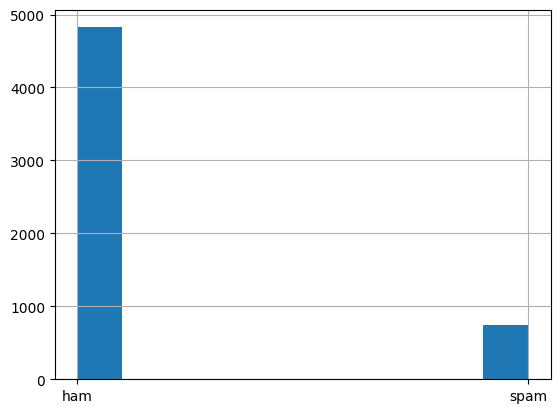

In [10]:
df['labels'].hist()

In [11]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()

In [12]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(
    df['data'], Y, test_size=0.33)

In [13]:
# try multiple ways of calculating features
# featurizer = TfidfVectorizer(decode_error='ignore')
# Xtrain = featurizer.fit_transform(df_train)
# Xtest = featurizer.transform(df_test)

featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [14]:
Xtrain

<3733x7014 sparse matrix of type '<class 'numpy.int64'>'
	with 49803 stored elements in Compressed Sparse Row format>

In [15]:
# creat the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.9930350924189659
test acc: 0.989668297988037


In [17]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.9751908396946565
test F1: 0.9559164733178654


In [18]:
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:", roc_auc_score(Ytrain, Prob_train))
print("test AUC:", roc_auc_score(Ytest, Prob_test))

train AUC: 0.9918534014087836
test AUC: 0.98409718698912


In [19]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3196,    9],
       [  17,  511]])

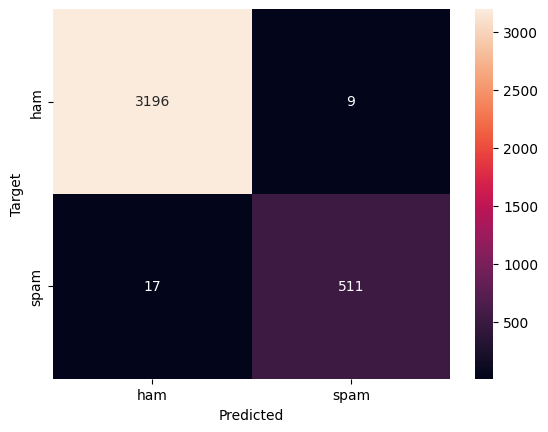

In [20]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['ham', 'spam']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

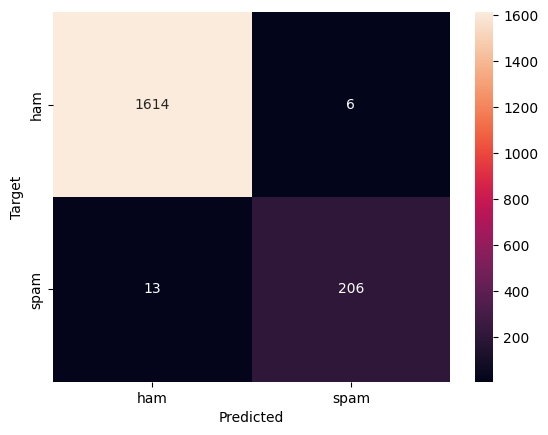

In [21]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

#confusion_matrix

In [22]:
# visualize the data
def visualize(label):
    words = ''
    for msg in df[df['labels'] == label]['data']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

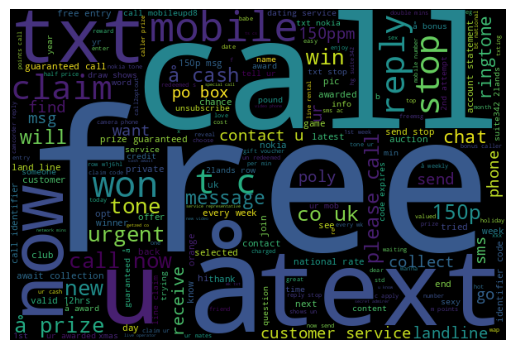

In [23]:
visualize('spam')

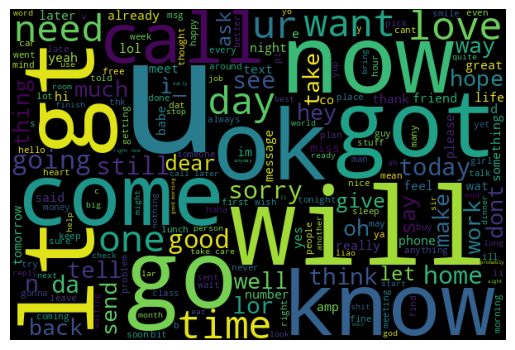

In [24]:
visualize('ham')

In [25]:
# see what we are getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [26]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
    print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Dont forget you can place as many FREE Requests with 1stchoice.co.uk as you wish. For more Information call 08707808226.
For sale - arsenal dartboard. Good condition but no doubles or trebles!
Hi its LUCY Hubby at meetins all day Fri & I will B alone at hotel U fancy cumin over? Pls leave msg 2day 09099726395 Lucy x Callså£1/minMobsmoreLKPOBOX177HP51FL
0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\"
Would you like to see my XXX pics they are so hot they were nearly banned in the uk!


In [27]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
    print(msg)

Finally the match heading towards draw as your prediction.
Waiting for your call.
Can u get pic msgs to your phone?
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Yavnt tried yet and never played original either
No pic. Please re-send.
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Gettin rdy to ship comp
Have you laid your airtel line to rest?
I liked the new mobile
Anytime...
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
